In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/objectdetectionmodel/pytorch/default/1/best_0.34.pt
/kaggle/input/crop_defect_detection_model/pytorch/default/1/best (2).pt
/kaggle/input/ghana-crop-disease-detection-data/SampleSubmission.csv
/kaggle/input/ghana-crop-disease-detection-data/Train.csv
/kaggle/input/ghana-crop-disease-detection-data/Test.csv
/kaggle/input/ghana-crop-disease-detection-data/images/id_p8dxgn.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_g2syp1.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_zx8php.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_6ne6qc.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_masrex.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_v9lx4u.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_qn4cyl.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_q97obi.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id_vxaj7n.jpg
/kaggle/input/ghana-crop-disease-detection-data/images/id

In [3]:
# Install ultralytics
!pip -q install  ultralytics

In [4]:
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Path to where your data is stored
DATA_DIR = Path('/kaggle/input/ghana-crop-disease-detection-data')

# Preview data files available
os.listdir(DATA_DIR)

['SampleSubmission.csv', 'images', 'Train.csv', 'Test.csv']

In [6]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [7]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('/kaggle/input/ghana-crop-disease-detection-data/images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('/kaggle/input/ghana-crop-disease-detection-data/images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  \
0   208.107730   341.967928   
1   162.910362   266.195724   
2   252.712993   338.876645   
3   238.593750   354.651316   
4  2184.252196  1401.748952   

                                          image_path  class_id  
0  /kaggle/input/ghana-crop-disease-detection-dat...         5  
1  /kaggle/input/ghana-crop-disease-detection-dat...         5  
2  /kaggle/input/ghana-crop-disease-detection-dat...         5  
3  /kaggle/input/ghana-crop-disease-detection-dat...         5  
4  /kaggle/input/ghana-crop-disease-detection-dat...         8

In [8]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

                                          image_path  
0  /kaggle/input/ghana-crop-disease-detection-dat...  
1  /kaggle/input/ghana-crop-disease-detection-dat...  
2  /kaggle/input/ghana-crop-disease-detection-dat...  
3  /kaggle/input/ghana-crop-disease-detection-dat...  
4  /kaggle/input/ghana-crop-disease-detection-dat...

In [8]:
ss.head()

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

In [9]:
# import pandas as pd

# # Set a random seed for reproducibility
# random_seed = 42

# # Select 30% of each dataframe
# train_sample = train.sample(frac=0.3, random_state=random_seed)
# test_sample = test.sample(frac=0.3, random_state=random_seed)
# ss_sample = ss.sample(frac=0.3, random_state=random_seed)

# # Print the sizes of the sampled dataframes to verify
# print("Train sample size:", train_sample.shape)
# print("Test sample size:", test_sample.shape)
# print("SS sample size:", ss_sample.shape)


In [9]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((30777, 9), (10252, 9))

In [10]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Corn_Cercospora_Leaf_Spot    0.160444
 Tomato_Septoria              0.159047
 Tomato_Late_Blight           0.098905
 Corn_Streak                  0.077201
 Tomato_Healthy               0.069045
 Pepper_Septoria              0.051922
 Pepper_Leaf_Mosaic           0.051662
 Tomato_Early_Blight          0.047763
 Pepper_Bacterial_Spot        0.047665
 Corn_Common_Rust             0.040290
 Pepper_Leaf_Curl             0.037561
 Corn_Healthy                 0.037561
 Tomato_Fusarium              0.019950
 Pepper_Healthy               0.017935
 Pepper_Late_Blight           0.014296
 Pepper_Leaf_Blight           0.012574
 Tomato_Bacterial_Spot        0.011860
 Pepper_Cercospora            0.011405
 Pepper_Fusarium              0.011340
 Tomato_Leaf_Curl             0.011177
 Corn_Northern_Leaf_Blight    0.004289
 Tomato_Mosaic                0.003314
 Pepper_Early_Blight          0.002794
 Name: proportion, dtype: float64,
 class
 Corn_Cercospora_Leaf_Spot    0.156067
 Tomato_Septori

In [11]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [12]:
TEST_IMAGES_DIR

PosixPath('datasets/dataset/images/test')

In [13]:

# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/3676 [00:00<?, ?it/s]

  0%|          | 0/1226 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [14]:
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations
def process_dataset(dataframe, output_dir):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use multiprocessing Pool to process tasks
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

100%|██████████| 1226/1226 [01:02<00:00, 19.72it/s]


In [15]:
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [16]:
DATASET_DIRt ='kaggle/working/'

# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': 'dataset/images/train',
    'val':  'dataset/images/val',
    'test': 'dataset/images/test',
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': 'dataset/images/train',
 'val': 'dataset/images/val',
 'test': 'dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_l1n94e.jpg with 7 bounding boxes.


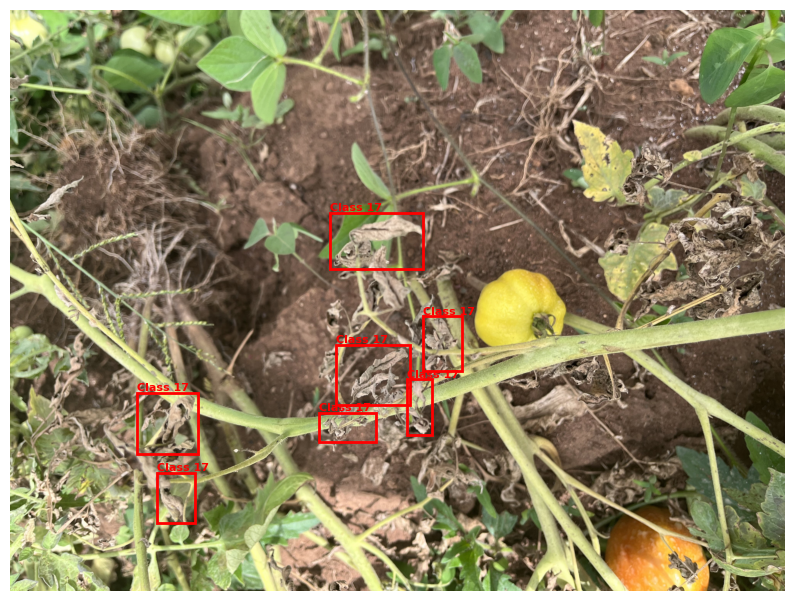

Plotting id_d3oz1q.jpg with 9 bounding boxes.


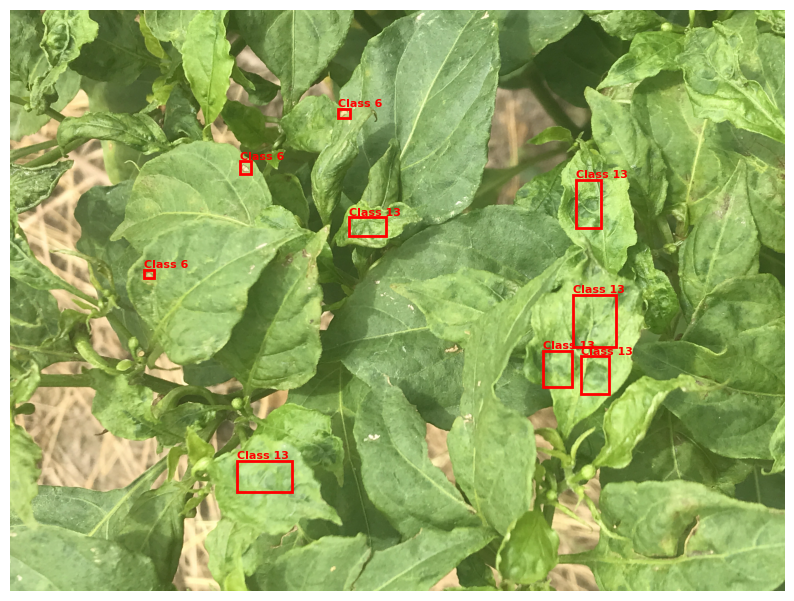

Plotting id_hvskl8.jpg with 3 bounding boxes.


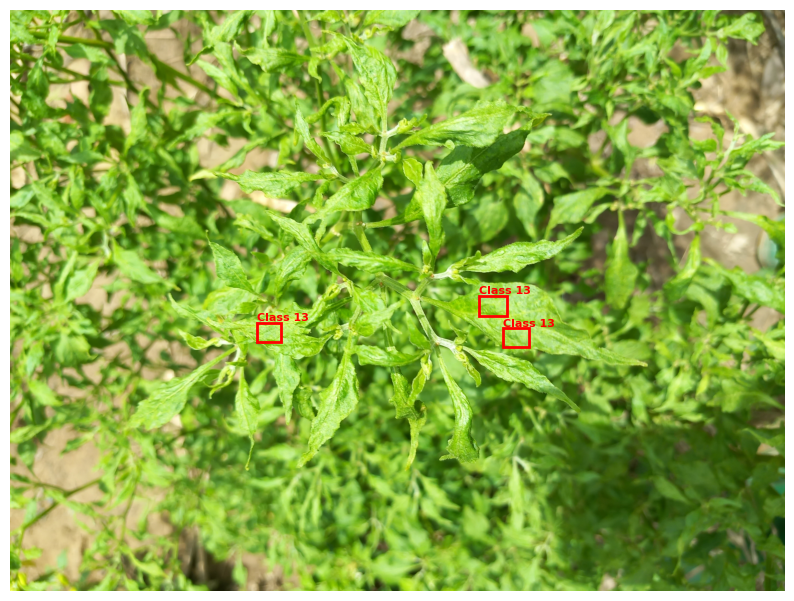

Plotting id_dwujh8.jpg with 3 bounding boxes.


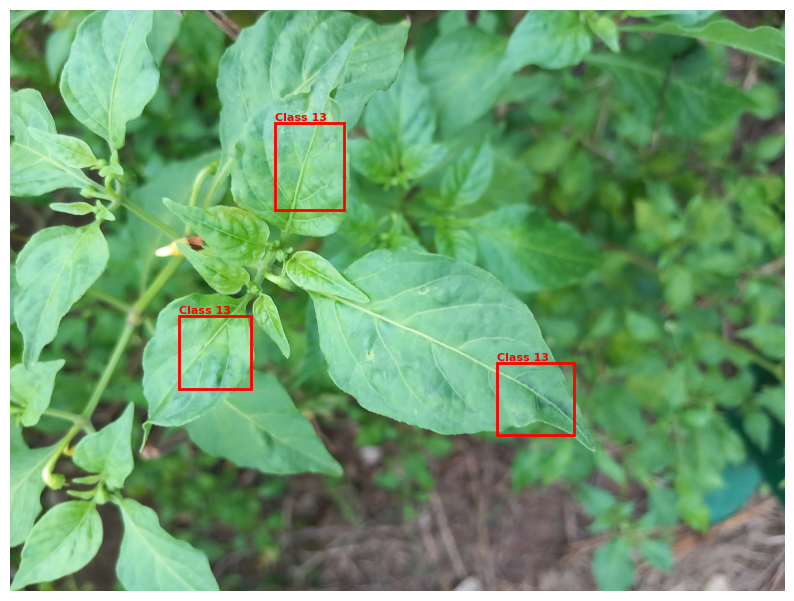

Plotting id_5dfjrx.jpg with 4 bounding boxes.


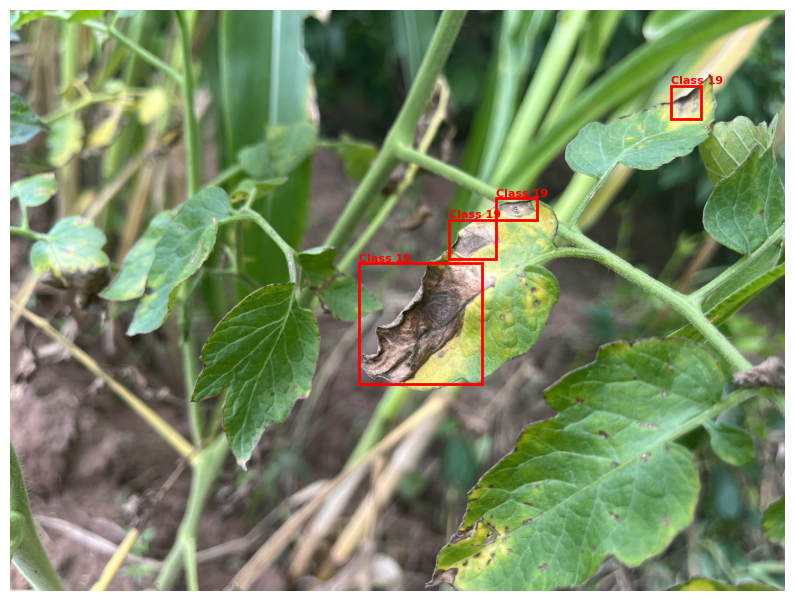

In [18]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [19]:
# Load a yolo pretrained model
model = YOLO('yolov8n.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=200,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=12,                   # Batch size
    device=1,                  # Device to use (0 for the first GPU)
    patience=5)

100%|██████████| 6.25M/6.25M [00:00<00:00, 22.2MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.14 torch-2.4.0 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=200, time=None, patience=5, batch=12, imgsz=1024, save=True, save_period=-1, cache=False, device=1, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

100%|██████████| 755k/755k [00:00<00:00, 4.51MB/s]
2025-01-30 22:24:24,807	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-30 22:24:25,301	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 19.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/dataset/labels/train... 3676 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3676/3676 [00:05<00:00, 637.66it/s] 


train: New cache created: /kaggle/working/datasets/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/dataset/labels/val... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:02<00:00, 577.93it/s]


val: New cache created: /kaggle/working/datasets/dataset/labels/val.cache


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      7.27G      2.398      4.702      1.935         49       1024: 100%|██████████| 307/307 [02:58<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:43<00:00,  1.18it/s]


                   all       1226      10252      0.411     0.0966     0.0379     0.0156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      5.28G       2.25      3.595      1.743         30       1024: 100%|██████████| 307/307 [02:53<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:42<00:00,  1.23it/s]


                   all       1226      10252      0.351      0.146     0.0669     0.0266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      5.98G      2.247       3.34      1.716         85       1024: 100%|██████████| 307/307 [02:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:45<00:00,  1.14it/s]


                   all       1226      10252      0.262       0.13     0.0532     0.0208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      5.31G      2.244      3.204      1.712         24       1024: 100%|██████████| 307/307 [02:52<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


                   all       1226      10252      0.233      0.135     0.0704     0.0273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       6.3G      2.236      3.018      1.692         36       1024: 100%|██████████| 307/307 [02:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.339      0.156     0.0852      0.034

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200       5.6G      2.217      2.859      1.684         31       1024: 100%|██████████| 307/307 [02:53<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.338      0.173     0.0949     0.0392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      5.48G      2.183      2.737      1.657         43       1024: 100%|██████████| 307/307 [02:53<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


                   all       1226      10252      0.322       0.17      0.103      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.35G      2.163      2.656      1.646         31       1024: 100%|██████████| 307/307 [02:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


                   all       1226      10252      0.418      0.223      0.129     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      5.81G      2.152      2.592      1.643         44       1024: 100%|██████████| 307/307 [02:53<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


                   all       1226      10252      0.379      0.204      0.135     0.0555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      5.68G      2.162      2.574      1.645         49       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


                   all       1226      10252      0.355      0.226      0.141     0.0607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.41G      2.135      2.501      1.628         60       1024: 100%|██████████| 307/307 [02:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.27it/s]


                   all       1226      10252      0.284      0.231      0.151     0.0625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      5.81G      2.133      2.473      1.611         18       1024: 100%|██████████| 307/307 [02:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.373      0.247      0.158      0.066

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      6.12G      2.112      2.429      1.607         66       1024: 100%|██████████| 307/307 [02:53<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.328      0.228      0.148     0.0616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      5.41G      2.116      2.425      1.599         58       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.381      0.238      0.156     0.0659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      5.83G      2.102       2.41      1.605         88       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.404      0.243      0.157     0.0654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.33G      2.095      2.385      1.593        109       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.282      0.245      0.182     0.0738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      7.64G      2.085      2.348      1.579        124       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.438      0.269      0.178      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      6.18G      2.083      2.341      1.583         58       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.27it/s]


                   all       1226      10252      0.366      0.255      0.186     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      6.74G      2.063      2.303      1.578         25       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.381      0.284      0.187     0.0789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.53G      2.071      2.276      1.565         97       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.323      0.269      0.172     0.0707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       6.7G      2.053      2.266      1.567         57       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252       0.37      0.275      0.202     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      6.69G      2.044      2.228      1.567         54       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.317       0.29      0.202     0.0827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      7.13G      2.058      2.259      1.565         71       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.431      0.257      0.201     0.0848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      6.18G       2.04       2.22      1.554         70       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


                   all       1226      10252      0.357      0.273      0.193      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      5.69G      2.033      2.229      1.551         63       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.24it/s]


                   all       1226      10252      0.406      0.273      0.208     0.0852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      5.66G      2.026      2.182      1.542         41       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.323      0.281      0.203     0.0872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      5.99G      2.013      2.178      1.534         52       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


                   all       1226      10252       0.35      0.286      0.207     0.0885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       5.9G      2.022      2.189      1.538         40       1024: 100%|██████████| 307/307 [02:52<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


                   all       1226      10252      0.354      0.277      0.217     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      5.64G       2.02      2.159      1.537         90       1024: 100%|██████████| 307/307 [02:52<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


                   all       1226      10252      0.337      0.285      0.213     0.0887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      6.54G      2.017      2.155      1.529         94       1024: 100%|██████████| 307/307 [02:52<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.26it/s]


                   all       1226      10252      0.357      0.303       0.22     0.0919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      6.07G      2.014      2.141      1.528         31       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252       0.34      0.316      0.232      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      5.48G      2.007      2.113      1.525         37       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.382      0.311      0.223     0.0944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       5.9G      2.008      2.103       1.51         62       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


                   all       1226      10252      0.361      0.319      0.239      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      5.94G      1.995       2.11       1.52         83       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.408      0.318      0.231      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      5.07G      1.995      2.086      1.501         38       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.27it/s]


                   all       1226      10252      0.393      0.317      0.244      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      5.97G      1.994      2.066      1.515         43       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


                   all       1226      10252      0.383      0.315      0.237      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.63G       1.99      2.073      1.506         55       1024: 100%|██████████| 307/307 [02:55<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.433      0.314      0.247      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      5.61G      1.989      2.062      1.513         51       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.417      0.305      0.254      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      5.18G      1.975      2.044      1.499        132       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252       0.37      0.329      0.251      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      5.43G      1.959      2.003      1.477         67       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.361      0.319      0.241      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      5.75G      1.965      2.017      1.494         38       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


                   all       1226      10252      0.414      0.331       0.26      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      6.08G      1.961      2.007      1.482         65       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.436      0.322       0.26      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.37G      1.979      2.027      1.504         43       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.389      0.307       0.25      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.59G      1.961      2.002      1.496         39       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.385      0.337      0.268      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200         6G      1.958      1.983      1.486         70       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


                   all       1226      10252      0.394      0.343      0.259      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.69G      1.957      1.983      1.476         57       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.379      0.325      0.254      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      5.63G      1.952       1.97      1.477         59       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.422      0.341      0.273      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      5.58G      1.954      1.975      1.486         44       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252       0.37      0.348      0.272      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.73G       1.95      1.977      1.473         28       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.392      0.337      0.276      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      5.23G      1.938      1.934       1.46         37       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


                   all       1226      10252       0.41      0.338      0.279      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      5.95G      1.925       1.93      1.467         43       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.399      0.336       0.27      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.04G      1.947      1.942      1.481         71       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252       0.42      0.349      0.289      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.68G      1.923      1.922      1.457         52       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.422      0.341      0.283      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      6.05G      1.922        1.9      1.455         92       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.454      0.346      0.287      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      5.77G      1.928      1.904      1.465         45       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.404      0.333       0.29      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      6.06G      1.924      1.904      1.456         57       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.428      0.344      0.294      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      6.25G      1.921      1.892      1.459         72       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.418      0.348      0.287      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      5.71G      1.904      1.895      1.456         59       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.411      0.338        0.3      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       5.9G      1.927      1.886      1.461         66       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252       0.44      0.345      0.303      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      6.85G        1.9      1.854      1.438         31       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


                   all       1226      10252      0.448      0.355      0.302      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      5.49G      1.913      1.866      1.451         74       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.444      0.338      0.301      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      7.17G      1.916      1.865      1.442         64       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


                   all       1226      10252      0.384       0.34      0.301      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      5.86G      1.891      1.856      1.441         58       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.357      0.363      0.311      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.06G      1.917      1.841      1.442         59       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.396      0.345      0.296       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      6.55G      1.894      1.826      1.423         28       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.407       0.36      0.308      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      6.65G      1.895      1.829      1.444         38       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252       0.41      0.357      0.319      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      6.01G      1.884       1.81      1.427         75       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.392      0.374       0.32      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.82G      1.889      1.794      1.426         73       1024: 100%|██████████| 307/307 [02:49<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.409       0.36      0.323      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      6.56G      1.886      1.792      1.418         45       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.32it/s]


                   all       1226      10252      0.363      0.354      0.312      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      5.88G      1.885      1.795      1.428        189       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.396      0.366       0.31      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      6.12G      1.878      1.794      1.431         81       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.419      0.363      0.325      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.78G      1.876       1.77      1.413         86       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252      0.381      0.356      0.327      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      7.15G      1.873      1.774      1.416         46       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:41<00:00,  1.27it/s]


                   all       1226      10252      0.468      0.371      0.331      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      6.72G       1.87      1.765      1.416         55       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


                   all       1226      10252      0.447       0.36      0.329      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.73G      1.869      1.746      1.403         84       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.30it/s]


                   all       1226      10252      0.382       0.37      0.336      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      5.96G      1.862      1.747       1.41         38       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.31it/s]


                   all       1226      10252       0.41      0.374      0.334      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      5.46G      1.861      1.759      1.414         33       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.421      0.355      0.321      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      5.66G      1.852      1.744      1.407         30       1024: 100%|██████████| 307/307 [02:49<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.371       0.39      0.332      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      7.45G      1.868      1.758      1.406         52       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.395      0.376      0.346      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      5.33G      1.849      1.735      1.406         37       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.33it/s]


                   all       1226      10252      0.403      0.385      0.346      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       7.1G      1.847       1.72      1.399         81       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.447      0.357      0.334      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      5.72G      1.852      1.727      1.405         77       1024: 100%|██████████| 307/307 [02:50<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:39<00:00,  1.30it/s]


                   all       1226      10252      0.403      0.391      0.348      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.27G      1.837      1.701      1.392         34       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.399      0.379      0.339      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.91G      1.841      1.694      1.395         24       1024: 100%|██████████| 307/307 [02:51<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.28it/s]


                   all       1226      10252      0.398      0.373      0.343      0.148
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 79, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

84 epochs completed in 4.984 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.14 torch-2.4.0 CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,010,133 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:40<00:00,  1.29it/s]


                   all       1226      10252      0.396      0.375      0.345      0.153
Corn_Cercospora_Leaf_Spot        202       1600      0.487      0.531      0.468      0.187
      Corn_Common_Rust         79        442      0.395      0.353      0.309      0.125
          Corn_Healthy         63        415      0.393      0.277      0.269     0.0963
Corn_Northern_Leaf_Blight         12         25      0.275       0.28      0.196      0.085
           Corn_Streak         87        804        0.4      0.424      0.376       0.13
 Pepper_Bacterial_Spot        132        476      0.386      0.246       0.24     0.0659
     Pepper_Cercospora         41        121       0.49      0.309       0.32      0.107
   Pepper_Early_Blight          2         15          0          0     0.0116    0.00426
       Pepper_Fusarium         52        123      0.539      0.675      0.642      0.232
        Pepper_Healthy         68        184      0.494      0.745      0.647      0.329
    Pepper_Late

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb75812cdc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0420

In [18]:
# Validate the model on the validation set
model = YOLO('/kaggle/input/crop_defect_detection_model/pytorch/default/1/best (2).pt')
results = model.val(data='data.yaml')

Ultralytics 8.3.94 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 17.0MB/s]
val: Scanning /kaggle/working/datasets/dataset/labels/val... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:01<00:00, 1032.51it/s]

val: New cache created: /kaggle/working/datasets/dataset/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:50<00:00,  1.52it/s]


                   all       1226      10252      0.743      0.705      0.754       0.48
Corn_Cercospora_Leaf_Spot        202       1600      0.705      0.441      0.576      0.245
      Corn_Common_Rust         79        442      0.708      0.487      0.567      0.331
          Corn_Healthy         63        415      0.701       0.54      0.672      0.382
Corn_Northern_Leaf_Blight         12         25      0.646       0.96      0.908      0.591
           Corn_Streak         87        804      0.709      0.536      0.641      0.305
 Pepper_Bacterial_Spot        132        476      0.705      0.445       0.55      0.198
     Pepper_Cercospora         41        121       0.73      0.785      0.786      0.452
   Pepper_Early_Blight          2         15      0.897          1      0.995      0.905
       Pepper_Fusarium         52        123      0.909      0.935      0.979      0.719
        Pepper_Healthy         68        184      0.807      0.918      0.933       0.65
    Pepper_Late

In [ ]:
import pandas as pd
from tqdm import tqdm
import os
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO('runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/kaggle/working/datasets/dataset/images/test'

# Load the original test file
test_df = pd.read_csv('/kaggle/input/ghana-crop-disease-detection-data/Test.csv')  # Replace with the actual path to your test file

# Create a set of valid Image_IDs for faster lookup
valid_image_ids = set(test_df['Image_ID'])

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each row in the test file
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_file = row['Image_ID']  # Assuming 'Image_ID' is the column name in your test file
    img_path = os.path.join(test_dir_path, image_file)
    
    # Make predictions on the image
    results = model(img_path)
    
    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary
    
    if boxes:  # If objects are detected
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary
            
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })
    else:  # If no objects are detected
        all_data.append({
            'Image_ID': image_file,
            'class': 'no_detection',  # or any default class you want to use
            'confidence': 0,
            'ymin': 0,
            'xmin': 0,
            'ymax': 0,
            'xmax': 0
        })

# Convert the list to a DataFrame
submission_df = pd.DataFrame(all_data)

# Filter out any Image_IDs that are not in the original test file (this should not be necessary, but just in case)
submission_df = submission_df[submission_df['Image_ID'].isin(valid_image_ids)]

# Save the submission file
# submission_df.to_csv('submission.csv', index=False)

print(f"Submission file created with {len(submission_df)} rows.")
print(f"Number of unique Image_IDs: {submission_df['Image_ID'].nunique()}")

In [ ]:
submission_df.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# # Create submission file to be uploaded to Zindi for scoring
sub.to_csv('submission1.csv', index = False)

In [ ]:
submission_df.to_csv('submission3.csv', index=False)
TEST_IMAGES_DIR

In [ ]:
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image, ImageDraw
import glob
from pathlib import Path
from IPython.display import display

# Load the fine-tuned model
model = YOLO('/kaggle/input/cropdefectyolomodel/pytorch/default/1/best (1).pt')

# Define transformation for image preprocessing
# Note: YOLOv8 handles image preprocessing internally, so we might not need this
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Match the training size if necessary
    transforms.ToTensor(),
])

# Function to perform prediction and visualization
def predict_and_visualize(image_path):
    # Since YOLOv8 handles image loading internally, we can directly pass the path
    results = model(image_path)  # results is a list of Results objects

    # Open the image for drawing
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)

        # Process each result in the list (in case of batch processing, though here we're processing one image at a time)
        for result in results:
            for *xyxy, conf, cls in result.boxes.data.tolist():
                x1, y1, x2, y2 = map(int, xyxy)
                # Draw bounding box
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                # Draw label and confidence
                label = f"{model.names[int(cls)]}: {conf:.2f}"
                draw.text((x1, y1), label, fill="red")

        # Display the image in the notebook
        display(img)

        # Optionally save the image
        output_path = Path(image_path).parent / f"predicted_{Path(image_path).name}"
        img.save(str(output_path))
        print(f"Image processed and saved: {image_path}")

# Loop through test images
TEST_IMAGES_DIR = Path('/kaggle/working/datasets/dataset/images/test/')
test_image_paths = glob.glob(str(TEST_IMAGES_DIR / '*.jpg'))[:6]  # Convert Path to string
for img_path in test_image_paths:
    predict_and_visualize(img_path)

In [19]:
loss_data = [
    {"box_loss": 2.027, "cls_loss": 2.242, "dfl_loss": 1.625},
    {"box_loss": 1.973, "cls_loss": 2.107, "dfl_loss": 1.596},
    {"box_loss": 1.916, "cls_loss": 1.939, "dfl_loss": 1.553},
    {"box_loss": 1.853, "cls_loss": 1.831, "dfl_loss": 1.506},
    {"box_loss": 1.852, "cls_loss": 1.768, "dfl_loss": 1.496},
    {"box_loss": 1.806, "cls_loss": 1.663, "dfl_loss": 1.462},
    {"box_loss": 1.787, "cls_loss": 1.64, "dfl_loss": 1.452},
    {"box_loss": 1.764, "cls_loss": 1.595, "dfl_loss": 1.443},
    {"box_loss": 1.728, "cls_loss": 1.535, "dfl_loss": 1.423},
    {"box_loss": 1.697, "cls_loss": 1.474, "dfl_loss": 1.402},
    {"box_loss": 1.678, "cls_loss": 1.445, "dfl_loss": 1.384},
    {"box_loss": 1.65, "cls_loss": 1.394, "dfl_loss": 1.369},
    {"box_loss": 1.62, "cls_loss": 1.343, "dfl_loss": 1.359},
    {"box_loss": 1.605, "cls_loss": 1.335, "dfl_loss": 1.343},
    {"box_loss": 1.621, "cls_loss": 1.345, "dfl_loss": 1.347},
    {"box_loss": 1.594, "cls_loss": 1.304, "dfl_loss": 1.337},
    {"box_loss": 1.583, "cls_loss": 1.297, "dfl_loss": 1.338},
    {"box_loss": 1.531, "cls_loss": 1.224, "dfl_loss": 1.297},
    {"box_loss": 1.518, "cls_loss": 1.215, "dfl_loss": 1.287},
    {"box_loss": 1.512, "cls_loss": 1.184, "dfl_loss": 1.311},
    {"box_loss": 1.483, "cls_loss": 1.128, "dfl_loss": 1.294},
    {"box_loss": 1.482, "cls_loss": 1.12, "dfl_loss": 1.295},
    {"box_loss": 1.441, "cls_loss": 1.087, "dfl_loss": 1.265},
    {"box_loss": 1.449, "cls_loss": 1.086, "dfl_loss": 1.273},
    {"box_loss": 1.423, "cls_loss": 1.05, "dfl_loss": 1.256},
      {"box_loss": 1.419, "cls_loss": 1.038, "dfl_loss": 1.254},
    {"box_loss": 1.383, "cls_loss": 1.011, "dfl_loss": 1.239},
    {"box_loss": 1.375, "cls_loss": 0.9978, "dfl_loss": 1.235},
    {"box_loss": 1.35, "cls_loss": 0.9693, "dfl_loss": 1.215},
    {"box_loss": 1.345, "cls_loss": 0.9654, "dfl_loss": 1.215},
    {"box_loss": 1.327, "cls_loss": 0.9351, "dfl_loss": 1.2},
    {"box_loss": 1.329, "cls_loss": 0.9245, "dfl_loss": 1.195},
    {"box_loss": 1.289, "cls_loss": 0.8916, "dfl_loss": 1.177},
    {"box_loss": 1.288, "cls_loss": 0.8918, "dfl_loss": 1.179},
    {"box_loss": 1.279, "cls_loss": 0.8797, "dfl_loss": 1.174},
    {"box_loss": 1.263, "cls_loss": 0.8711, "dfl_loss": 1.163},
    {"box_loss": 1.249, "cls_loss": 0.8633, "dfl_loss": 1.16},
    {"box_loss": 1.238, "cls_loss": 0.8367, "dfl_loss": 1.15},
    {"box_loss": 1.218, "cls_loss": 0.8214, "dfl_loss": 1.142},
    {"box_loss": 1.21, "cls_loss": 0.8148, "dfl_loss": 1.138},
    {"box_loss": 1.205, "cls_loss": 0.8175, "dfl_loss": 1.14},
    {"box_loss": 1.198, "cls_loss": 0.7932, "dfl_loss": 1.125},
    {"box_loss": 1.166, "cls_loss": 0.7821, "dfl_loss": 1.122},
    {"box_loss": 1.162, "cls_loss": 0.7744, "dfl_loss": 1.121},
    {"box_loss": 1.149, "cls_loss": 0.752, "dfl_loss": 1.108}
]

box_loss = [entry["box_loss"] for entry in loss_data]
cls_loss = [entry["cls_loss"] for entry in loss_data]
dfl_loss = [entry["dfl_loss"] for entry in loss_data]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

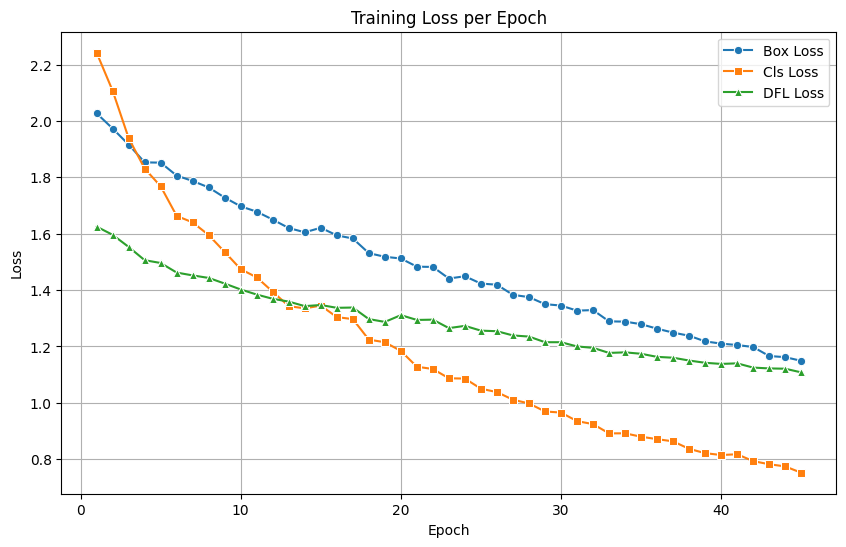

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracted data
epochs = list(range(1, 46))  # Assuming we have 21 epochs
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=box_loss, label='Box Loss', marker='o')
sns.lineplot(x=epochs, y=cls_loss, label='Cls Loss', marker='s')
sns.lineplot(x=epochs, y=dfl_loss, label='DFL Loss', marker='^')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
